In [76]:
import json

In [77]:
def parse_data(path):
    for l in open(path,'r'):
        yield json.loads(l)
    

In [78]:
data = list(parse_data('./Sarcasm_Headlines_Dataset_v2.json'))
heads,labels = [],[]
for item in data:
    heads.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [106]:
import nltk

In [79]:
len([a for a in labels if a==1]) # Count of Sasrcastic Headlines

13634

In [80]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [81]:
char_dataset = tf.data.Dataset.from_tensor_slices((heads,labels))

In [82]:
for example, label in char_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'thirtysomething scientists unveil doomsday clock of hair loss'
label:  1


In [83]:
data_size = len(data)
train_size = int(0.7 * data_size )
test_size = int(0.3 * data_size )

train_data = char_dataset.take(train_size)
test_data = char_dataset.skip(train_size)

In [84]:
buffer_size = 1000
batch_size = 128

train_data = train_data.shuffle(buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

In [85]:
vocab_size=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_data.map(lambda text, label: text))

In [86]:
for example, label in train_data.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])


texts:  [b'how to dress like an nfl superfan and still look good'
 b'brett kavanaugh reiterates cruel and unusual punishment what makes someone a true kappa'
 b'hey, remember when bernie sanders played a rabbi in a rom-com?']

labels:  [0 1 0]


In [87]:
'''vocab = np.array(encoder.get_vocabulary())
vocab[:25]'''

'vocab = np.array(encoder.get_vocabulary())\nvocab[:25]'

In [94]:
model = tf.keras.Sequential( [
    encoder,
    tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [95]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [96]:
history = model.fit(train_data, epochs=25,
                    validation_data=test_data, 
                    validation_steps=30)

Epoch 1/25
157/157 [==============================] - 8s 50ms/step - loss: 0.6867 - accuracy: 0.5232 - val_loss: 0.6585 - val_accuracy: 0.5190
Epoch 2/25
157/157 [==============================] - 4s 25ms/step - loss: 0.5107 - accuracy: 0.7018 - val_loss: 0.4276 - val_accuracy: 0.7690
Epoch 3/25
157/157 [==============================] - 4s 25ms/step - loss: 0.4147 - accuracy: 0.7912 - val_loss: 0.3966 - val_accuracy: 0.7987
Epoch 4/25
157/157 [==============================] - 4s 25ms/step - loss: 0.3844 - accuracy: 0.8109 - val_loss: 0.3809 - val_accuracy: 0.8146
Epoch 5/25
157/157 [==============================] - 4s 25ms/step - loss: 0.3654 - accuracy: 0.8260 - val_loss: 0.3727 - val_accuracy: 0.8273
Epoch 6/25
157/157 [==============================] - 4s 25ms/step - loss: 0.3538 - accuracy: 0.8373 - val_loss: 0.3707 - val_accuracy: 0.8146
Epoch 7/25
157/157 [==============================] - 4s 25ms/step - loss: 0.3436 - accuracy: 0.8434 - val_loss: 0.3637 - val_accuracy: 0.8331

In [97]:
test_loss, test_acc = model.evaluate(test_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))


68/68 [==============================] - 1s 15ms/step - loss: 0.3960 - accuracy: 0.8242
Test Loss: 0.39599448442459106
Test Accuracy: 0.8242487907409668


In [98]:
import matplotlib.pyplot as plt
def plot_graphs(hist,metric):
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.legend([metric,'val_'+metric])

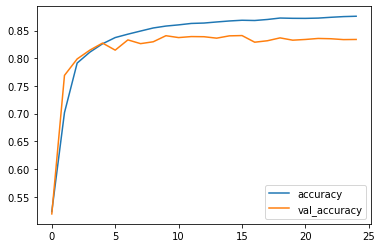

In [99]:
plot_graphs(history,'accuracy')

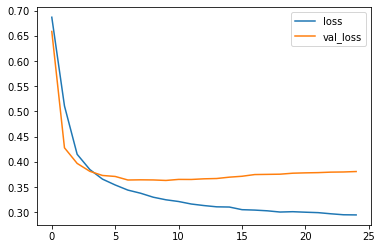

In [100]:
plot_graphs(history,'loss')

In [101]:
n = 8486
heads[n],labels[n]

('christmas pageant enters pre-production', 1)

In [102]:
# Testing

sample = heads[n]
preds = model.predict(np.array([sample]))

In [103]:
preds

array([[0.9125291]], dtype=float32)

In [104]:
model.save('test1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: test1\assets


In [ ]:
loaded_model = tf.keras.models.load_model('test1')